# Generating Audio with Simple Diffusion

## Setup

In [1]:
#!pip install -q miniminiai datasets diffusers torchaudio

In [15]:
import torch, random
import numpy as np
import torch.nn as nn
import fastcore.all as fc
import torch.nn.functional as F
from PIL import Image
from torch import optim
from miniai.imports import *
from miniai.diffusion import *
from functools import partial
from datasets import load_dataset
from IPython.display import Audio
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt
from torchaudio import transforms as AT
from torch.utils.data import default_collate
from torchvision.transforms import functional as TF
from diffusers import Mel

## Loading Audio Data

In [3]:
# Settings for the Mel Spectrograms we'll use
sample_rate_mel = 16000
x_res = 128 # x resolution of spectrogram (time)
y_res = 128 # y resolution of spectrogram (frequency bins)
mel = Mel(x_res, y_res, sample_rate_mel)

In [4]:
# The dataset of bird calls
birdcall_dataset = load_dataset('tglcourse/5s_birdcall_samples_top20')

In [5]:
birdcall_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 9595
    })
})

In [6]:
birdcall_dataset['train'][0]

{'audio': <datasets.features._torchcodec.AudioDecoder at 0x7e59546ace90>,
 'label': 'rewbla'}

In [7]:
# We need to re-sample the audio to match our target sample rate
sample_rate_dataset = 32000
resampler = AT.Resample(sample_rate_dataset, sample_rate_mel, dtype=torch.float32)

In [8]:
# Transform to turn an audio array into a PIL image
import random
def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32)
  audio_tensor = resampler(audio_tensor)
  mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = mel.get_number_of_slices()
  slice_idx = random.randint(0, num_slices-1) # Pic a random slice each time (excluding the last short slice)
  im = mel.audio_slice_to_image(slice_idx)
  return im

In [9]:
# The dataset returns the image
class ImagesDS:
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self): return len(self.dataset)
    def __getitem__(self, i):
        audio_array = self.dataset[i]['audio']['array']
        im = to_image(audio_array)
        im = TF.to_tensor(im) - 0.5
        im = TF.resize(im, (x_res, y_res))
        return (im,)

In [10]:
# Train and val datasets
tds = ImagesDS(birdcall_dataset['train'].select(range(9000)))
vds = ImagesDS(birdcall_dataset['train'].select(range(9000, 9500)))

In [11]:
# Our data is effeectively 'greyscale images'
tds[0][0].shape

torch.Size([1, 128, 128])

/tmp/ipykernel_17249/2099326365.py:4: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(im.astype(np.uint8), mode='L')


(65024,)


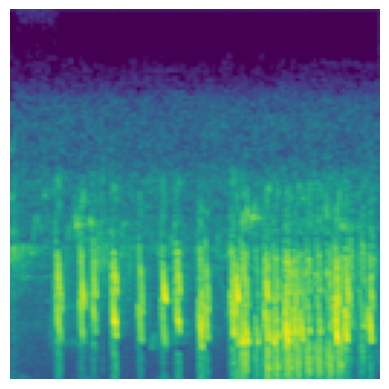

In [12]:
# View a random sample
idx = random.randint(0, 1000)
im = np.array((tds[idx][0][0]+0.5).clip(0, 1)*255) # (64, 64)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
print(a.shape)
show_image(im)
display(Audio(a, rate=16000))

## Dataloaders

Here the dataloader adds noise using noisify, so a batch now has images + noise level

In [22]:
# Dataloaders
bs=16
def collate_ddpm(b): return noisify(default_collate(b)[0])
dls = DataLoaders(
    *get_dls(tds, vds, bs=bs, num_workers=32, collate_fn=collate_ddpm)
)

In [23]:
batch = next(iter(dls.train))
batch[0][0].shape

torch.Size([16, 1, 128, 128])

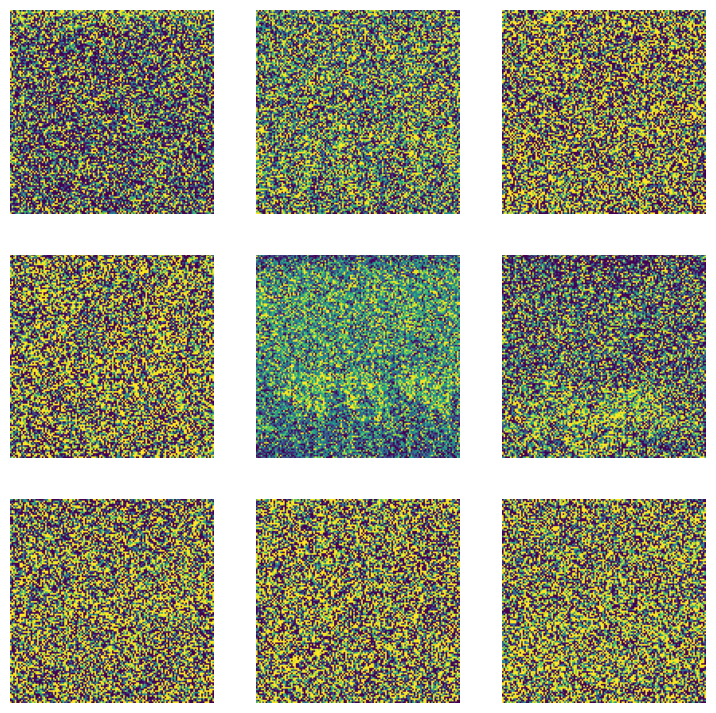

In [24]:
show_images(batch[0][0][:9].clip(-0.5, 0.5)+0.5)

## Model + training

In [25]:
#@markdown model def copied from https://github.com/fastai/course22p2/blob/master/nbs/30_lsun_diffusion-simple.ipynb

class LearnEmbSS(nn.Module):
    def __init__(self, sz, ni):
        super().__init__()
        self.scale = nn.Parameter(torch.zeros(sz, ni))
        self.shift = nn.Parameter(torch.zeros(sz, ni))

    def forward(self, x): return x*self.scale + self.shift


def _mlp(ni, nh):
    return nn.Sequential(nn.Linear(ni,nh), nn.GELU(), nn.LayerNorm(nh), nn.Linear(nh,ni))

class EmbTransformerBlk(nn.Module):
    def __init__(self, n_emb, ni, attn_chans=8):
        super().__init__()
        self.attn = SelfAttention(ni, attn_chans=attn_chans, transpose=False)
        self.mlp = _mlp(ni, ni*4)
        self.nrm1 = nn.LayerNorm(ni)
        self.nrm2 = nn.LayerNorm(ni)
        self.emb_proj = nn.Linear(n_emb, ni*2)

    def forward(self, x, t):
        emb = self.emb_proj(F.silu(t))[:, None]
        scale,shift = torch.chunk(emb, 2, dim=2)
        x = x + self.attn(self.nrm1(x))
        x = x*(1+scale) + shift
        return x + self.mlp(self.nrm2(x))

class SimpleDiffusion(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1,
                 attn_chans=8, attn_start=1, n_mids=8):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))

        self.le = LearnEmbSS(64, nf)
        self.mids = nn.ModuleList([EmbTransformerBlk(n_emb, nf) for _ in range(n_mids)])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        n,c,h,w = x.shape
        x = self.le(x.reshape(n,c,-1).transpose(1,2))
        for block in self.mids: x = block(x, emb)
        x = x.transpose(1,2).reshape(n,c,h,w)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [26]:
lr = 1e-4
epochs = 15
opt_func = partial(optim.AdamW, eps=1e-5, weight_decay=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), TrainCB()]
model = SimpleDiffusion(in_channels=1, out_channels=1, nfs=(16,32,256,384,512), num_layers=1, attn_chans=0, n_mids=6)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/simple-diffusion-audio.pkl')

## Sampling

Regular DDIM sampling, and then we turn the resulting images into audio using `mel.image_to_audio`

In [ ]:
sz = (9,1,x_res,y_res)
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=1.):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = (x_t-(1-abar_t).sqrt()*noise  )   / abar_t.sqrt()
    if clamp: x_0_hat = x_0_hat.clamp(-clamp,clamp)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
# s = preds[-1]
s.min(),s.max(),s.shape
show_images(s[:9].clamp(0,1), imsize=2)

In [ ]:
idx = 7
im = np.array((s[idx][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
print(a.shape)
show_image(im)
display(Audio(a, rate=16000))

In [ ]:
# Generate a single sample
sz = (1,1,x_res,y_res)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
im = np.array((s[0][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
show_image(im)
display(Audio(a, rate=16000))

In [ ]:
# Generate a single sample
sz = (1,1,x_res,y_res)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
im = np.array((s[0][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
show_image(im)
display(Audio(a, rate=16000))

In [ ]:
# Generate a single sample
sz = (1,1,x_res,y_res)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
im = np.array((s[0][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
show_image(im)
display(Audio(a, rate=16000))